# Reading dataset 

In [1]:
import pandas as pd

In [2]:
def read_dataset(index):
    DATA_PATH = '../data/'
    if index < 10:
        index = '0' + str(index)
    else:
        index = str(index)
    train = pd.read_csv(DATA_PATH + index + '_train.csv')
    y_train = train.y
    X_train = train.drop(columns=['y'])
    test = pd.read_csv(DATA_PATH + index + '_test.csv')
    y_test = test.y
    X_test = test.drop(columns=['y'])
    return X_train, y_train, X_test, y_test

# Analyzing desicionTreeClassifieer

## Hyperparam optimization with early stopping

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

In [4]:
def hyperparameter_optimization(X_train, y_train, X_test, y_test):
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25)
    best_accuracy = -1
    best_params = None
    for criterion in ['gini', 'entropy']:
        for splitter in ['best', 'random']:
            current_accuracy = -1
            max_depth = 0
            early_stopping_counter = 0
            while early_stopping_counter < 25:
                max_depth += 1
                classifier = DecisionTreeClassifier(criterion = criterion, splitter = splitter, max_depth = max_depth)
                classifier.fit(X_train, y_train)
                y_pred = classifier.predict(X_valid)
                accuracy = accuracy_score(y_pred, y_valid)
                if accuracy > current_accuracy:
                    current_accuracy = accuracy
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
            if current_accuracy > best_accuracy:
                best_params = [criterion, splitter, max_depth - 10]
                best_accuracy = current_accuracy
    return best_params, best_accuracy

In [5]:
min_depth = 1e10
min_depth_params = None
max_depth = -1
max_depth_params = None

for i in tqdm(range(1, 21)):
    X_train, y_train, X_test, y_test = read_dataset(i)
    params, accuracy = hyperparameter_optimization(X_train, y_train, X_test, y_test)
    if params[2] < min_depth:
        min_depth_params = [i] + params + [accuracy]
        min_depth = params[2]
    if params[2] > max_depth:
        max_depth_params = [i] + params + [accuracy]
        max_depth = params[2]

In [6]:
min_depth_params

[3, 'gini', 'best', 16, 0.9460500963391136]

In [7]:
max_depth_params

[9, 'gini', 'best', 27, 0.71875]

## Analyzing best models

In [8]:
import matplotlib.pyplot as plt

In [9]:
def plot_train_test_accuracy(params):
    X_train, y_train, X_test, y_test = read_dataset(params[0])
    depth = params[3]
    train_accuracy = []
    test_accuracy = []
    for max_depth in range(1, depth + 2):
        classifier = DecisionTreeClassifier(criterion = params[1], splitter = params[2], max_depth = max_depth)
        classifier.fit(X_train, y_train)
        train_accuracy.append(accuracy_score(classifier.predict(X_train), y_train))
        test_accuracy.append(accuracy_score(classifier.predict(X_test), y_test))
    plt.plot(range(1, depth + 2), test_accuracy, color='orange', label='test')
    plt.plot(range(1, depth + 2), train_accuracy, color='darkblue', label='train')
    plt.xlabel('Max depth')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

### min depth

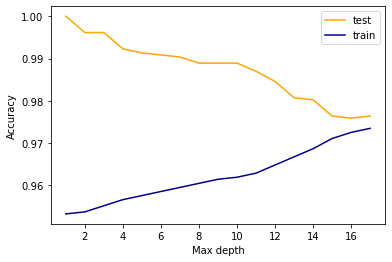

In [10]:
plot_train_test_accuracy(min_depth_params)

### max depth

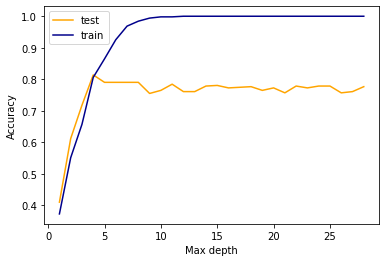

In [11]:
plot_train_test_accuracy(max_depth_params)

## RandomForestClassifier

In [50]:
import random
import math
import numpy as np

In [61]:
class RandomForestClassifier:
    
    class DecisionTree:
        def __init__(self, features_size=lambda x: round(math.sqrt(x))):
            self.features_size = features_size
        def fit(self, X, y):
            self.features_indices = random.sample(range(len(X.columns)), k = self.features_size(len(X.columns)))
            X = X.copy()
            X = X.iloc[:, self.features_indices]
            self.clf = DecisionTreeClassifier()
            self.clf.fit(X, y)
        def predict(self, X):
            X = X.copy()
            X = X.iloc[:, self.features_indices]   
            return self.clf.predict(X)                                      
            
            
    def __init__(self, n_trees=10, sample_size=lambda x: x, features_size=lambda x: round(math.sqrt(x))):
        self.sample_size = sample_size
        self.features_size = features_size
        self.n_trees = n_trees
                                                  
    def fit(self, X, y):
        self.trees = []
        for i in range(self.n_trees):
            classifier = self.DecisionTree()
            
            indices = [random.choice(range(len(X))) for _ in range(self.sample_size(len(X)))]
            X_data = X.iloc[indices]
            y_data = y.iloc[indices]
            
            classifier.fit(X_data, y_data)
            self.trees.append(classifier)
                                                  
    def predict(self, X):
        predicted = []
        for tree in self.trees:
            predicted.append(tree.predict(X))
        predicted = np.array(predicted)
        y_pred = []
        for column in predicted.T:
            frequency_array = np.bincount(column)
            y_pred.append(np.argmax(frequency_array))
        return np.array(y_pred)

In [68]:
best_dataset = -1
best_dataset_accuracy = -1

for i in tqdm(range(1, 21)):
    X_train, y_train, X_test, y_test = read_dataset(i)
    classifier = RandomForestClassifier(n_trees=100)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)
    if accuracy > best_dataset_accuracy:
        best_dataset_accuracy = accuracy
        best_dataset = i
    if accuracy < worst_dataset_accuracy:
        worst_dataset_accuracy = accuracy
        worst_dataset = i

### Analyzing best

In [69]:
def plot_train_test_accuracy_rf(i, n_trees=100):
    X_train, y_train, X_test, y_test = read_dataset(i)
    train_accuracy = []
    test_accuracy = []
    for max_trees in range(1, n_trees):
        classifier = RandomForestClassifier(n_trees=max_trees)
        classifier.fit(X_train, y_train)
        train_accuracy.append(accuracy_score(classifier.predict(X_train), y_train))
        test_accuracy.append(accuracy_score(classifier.predict(X_test), y_test))
    plt.plot(range(1, n_trees), test_accuracy, color='orange', label='test')
    plt.plot(range(1, n_trees), train_accuracy, color='darkblue', label='train')
    plt.xlabel('Trees count')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

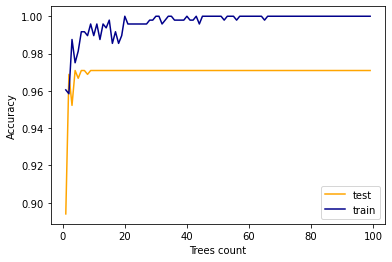

In [70]:
plot_train_test_accuracy_rf(best_dataset)